In [227]:
import sys
import numpy as np
import pandas as pd
import sympy

from matplotlib import collections  as mc
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import urllib.request
from scipy.spatial import KDTree

In [5]:
!mkdir TSPLIB_DATA

mkdir: TSPLIB_DATA: File exists


In [6]:
TSPLIB_DATA="./TSPLIB_DATA/"

# Download sample TSLIB instances

In [9]:
def download_tsplib_instance(instance_name="a280.tsp"):
    
    base_url = "https://raw.githubusercontent.com/yafeunteun/tsplib/master/"
    complete_url = base_url + instance_name
    output_filepath = TSPLIB_DATA + instance_name
    urllib.request.urlretrieve(complete_url, output_filepath)

In [10]:
download_tsplib_instance()

In [13]:
!ls TSPLIB_DATA
!head TSPLIB_DATA/a280.tsp

a280.tsp
NAME : a280
COMMENT : drilling problem (Ludwig)
TYPE : TSP
DIMENSION: 280
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
  1 288 149
  2 288 129
  3 270 133
  4 256 141


# Read TSPLIB

In [54]:
def read_tsplib(filepath_to_tsplib_file):
    coordinates = [] 
    dim = 0
    start_read_coords = False
    with open(filepath_to_tsplib_file, "r") as f:
        line = f.readline().strip() or "EOF"
        while not line.startswith("EOF"):
            if start_read_coords:
                _id, x, y = (float(x) for x in line.split())
                coordinates.append((x,y))
            if line.startswith("DIMENSION"):
                dim = int(line.split(':')[1].strip())
            if line.startswith("NODE_COORD_SECTION"):
                start_read_coords = True
            line = f.readline().strip()
    assert len(coordinates) == dim, "Number of coordinates doesn't match the dimension parameter in file."
    
    return coordinates

In [55]:
coords = read_tsplib(TSPLIB_DATA + 'a280.tsp')

In [56]:
coords[:5]

[(288.0, 149.0),
 (288.0, 129.0),
 (270.0, 133.0),
 (256.0, 141.0),
 (256.0, 157.0)]

# KDTree

In [60]:
kdtree = KDTree(coords, leafsize=15)

In [62]:
cityID = 0
coords[cityID]

(288.0, 149.0)

In [70]:
distances, ids = kdtree.query(coords[cityID], 15)

In [71]:
ids

array([  0, 279,   1,   2,   3,   4, 278, 241, 242,   5, 276, 277, 240,
       247, 243])

# TSP utils

In [202]:
def score_tour(tour, cities=coords):
    df = pd.DataFrame()
    df['CityId'] = range(len(cities))
    df['X'] = np.array(coords)[:,0]
    df['Y'] = np.array(coords)[:,1]
    df = df.reindex(tour + [0]).reset_index()
    primes = list(sympy.primerange(0, len(cities)))
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
    return df.dist.sum() #+ df.penalty.sum()

In [136]:
def plot_path(path, coordinates, k=0):
    # Plot tour
    lines = []
    distances = [] 
    for i in range(1, len(path)):
        line = [coordinates[path[i-1]], coordinates[path[i]]]
        (x1, y1), (x2, y2) = line
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        distances.append(distance)   
        if distance > k:
            lines.append(line)
        
    lc = mc.LineCollection(lines, linewidths=2)
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_aspect('equal')
    plt.grid(False)
    ax.add_collection(lc)
    ax.autoscale()
    #return distances

# Heuristics

## 2-OPT

In [203]:
route = list(range(len(coords))) + [0]

In [204]:
score_tour(route, coords)

2818.6216422394723

In [228]:
def two_opt(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in tqdm(range(1, len(route)-2)):
            for j in range(i+1, len(route)):
                if j-i == 1: continue # changes nothing, skip then                
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
                if score_tour(new_route) < score_tour(best):
                    print(score_tour(best))
                    best = new_route
                    improved = True
        route = best
    return best

In [229]:
route = list(range(len(coords))) + [0]
route = two_opt(route)

  1%|          | 2/278 [00:06<15:46,  3.43s/it]

2818.6216422394723
2817.7864752705154


  4%|▎         | 10/278 [00:29<14:01,  3.14s/it]

KeyboardInterrupt: 

In [234]:
def two_opt_fast(route):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route)-2):
            for j in kdtree.query(coords[route[i]], 15)[1][1:]:
                pos_j = route.index(j)
                if j == route[i+1]: break # changes nothing, skip then  
                if pos_j <= i: continue
                new_route = route[:]
                new_route[i:pos_j] = route[pos_j-1:i-1:-1] # this is the 2woptSwap
                if score_tour(new_route) < score_tour(best):
                    print(score_tour(best))
                    best = new_route
                    improved = True
        route = best
    return best

In [235]:
route = list(range(len(coords))) + [0]
route = two_opt_fast(route)

2818.6216422394723
2817.7864752705154
2814.167831161837
2813.33266419288
2811.2645464550797
2810.4293794861223
2807.3898431542034
2807.389843154203
2804.350306822284
2802.4753366429923


## 3-opt

In [ ]:
def three_opt(tour):
    "Iterative improvement based on 3 exchange."
    while True:
        delta = 0
        for (a,b,c) in all_segments(len(tour)):
            delta += reverse_segment_if_better(tour, a, b, c)
        if delta >= 0:
            break
    return tour

def all_segments(N):
    "Generate all segments combinations"
    return ((i, j, k)
        for i in range(N)
        for j in range(i+2, N)
        for k in range(j+2, N+(i>0)))

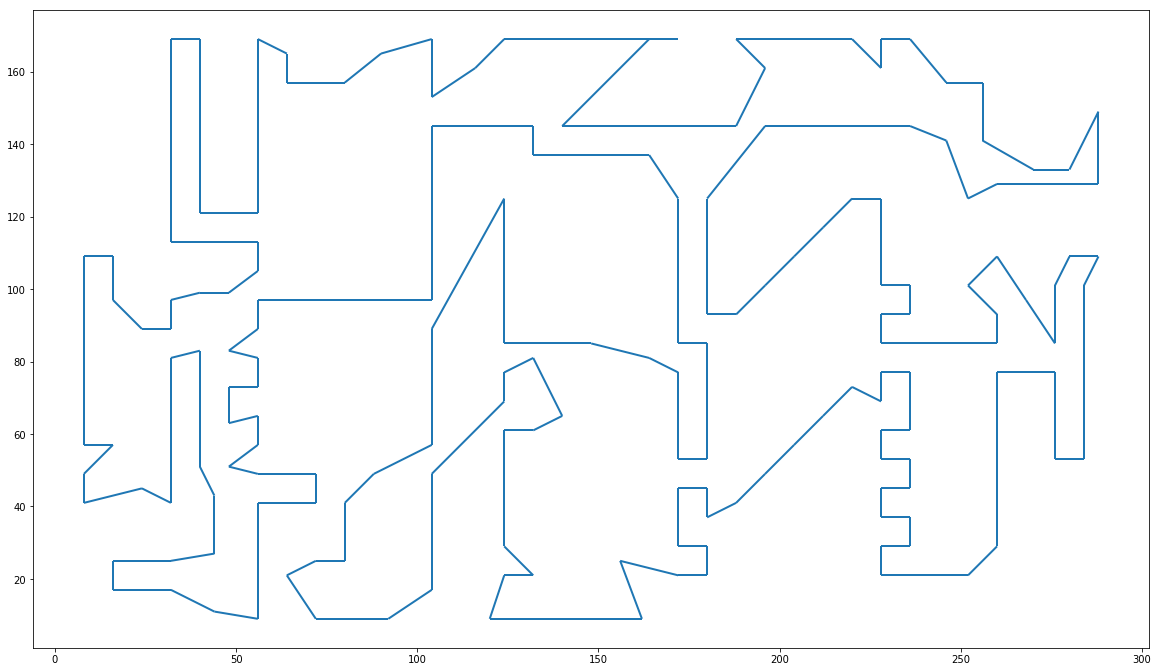

In [236]:
plot_path(route, coords)